# Assignment

In this homework you will explore a relatively large corpus of emails released in public during the Hillary Clinton email controversy. You can find the corpus in the `data` directory of this repository, while more detailed information about the schema is available [here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

# Getting started

## Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import nltk
import pickle
import string

from wordcloud import WordCloud # pip install wordcloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer

import pycountry
from gensim import corpora, models, similarities

## Read data

After checking the data scheme on [Kaggle](https://www.kaggle.com/kaggle/hillary-clinton-emails), only two things are possibly useful:
- `ExtractedSubject` and `ExtractedBodyText`: an attempt to retrieve the subject and text from PDF file.
- `RawText`: in case the previous attempt failed, we might need to do it on our own.

In [134]:
# read csv file and retrieve desired columns
raw = pd.read_csv('data/Emails.csv')
extractedMail = raw[['ExtractedSubject', 'ExtractedBodyText']]
extractedMail = extractedMail.fillna('')
rawMail = raw[['RawText']]
rawMail = rawMail.fillna('')

extractedMail.head()

,ExtractedSubject,ExtractedBodyText
0,FW: Wow,
1,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Re: Chris Stevens,Thx
3,FVV: Cairo Condemnation - Final,
4,,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


Whoops, it seems that the attempt to pull out the text is not a great success. But let's save the data frames first before generating a word cloud.

In [98]:
extractedMail.to_csv(r'data/extractedMail.txt', header=None, index=None, sep=' ')
rawMail.to_csv(r'data/rawMail.txt', header=None, index=None, sep=' ')

# Taming text

## Task 1 - Generate word clouds

In task 1 we are going to generate two word clouds: one based on the raw corpus, and one based on pre-processed corpus.

### Word cloud for raw corpus

We are going to use `extractedMail.txt` as our raw corpus, since it excludes some noise already when created.

In [99]:
# set max words to 200 to simplify visualization
corpus = open('data/extractedMail.txt').read()
wordcloud = WordCloud(height=1000, width=2000, max_words=200).generate(corpus)

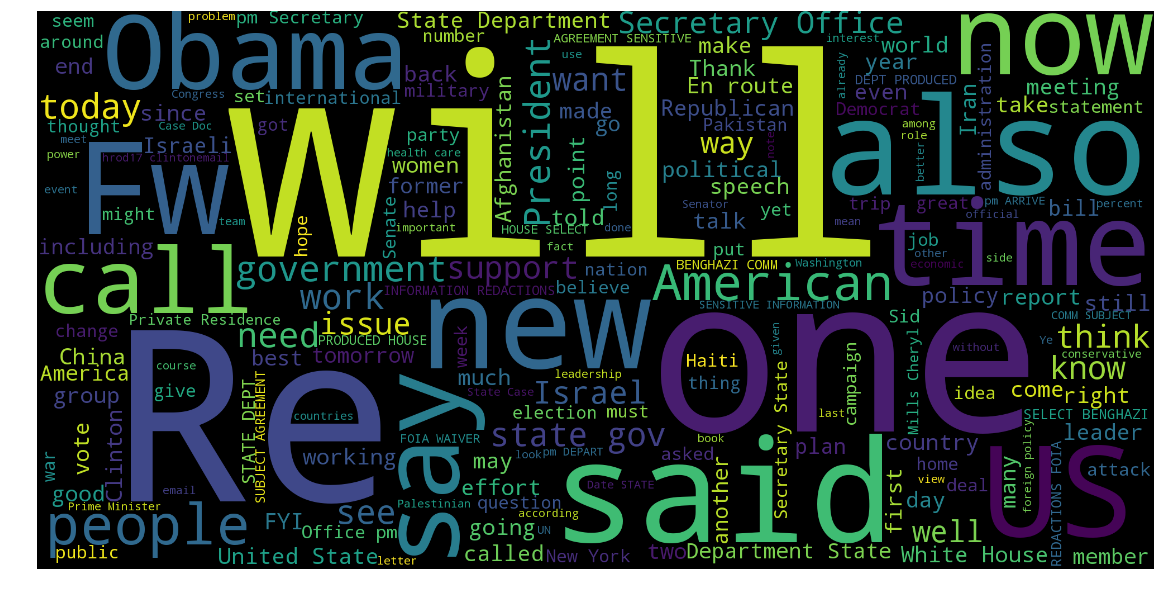

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

__Summary:__ It looks good. It's kind of expected to see the heaviest words are mostly stopwords, because the corpus has not been pre-processed. It seems wordcloud can remove some common stopwords in advance. We are really happy to see some words such as __`Obama`__ and __`Israel`__ sitting at second tier, since they would relate to a specific topic and benefit topic modeling later.

### Word cloud for pre-processed corpus

Now we try to pre-process the corpus with the help of `nltk`. The steps are:
- __Tokenize__ the raw corpus.
- Delete __stopwords__ from the tokenized corpus. Stopwords are cached in advance.
- __Lemmatize__ and __stem__ the corpus.
- Remove all punctuations.

Everything can be encapsulated in the following function.

In [119]:
def preprocessing(corpus, stopwords, verify=True):
    # tokenize the corpus
    # nltk.download('punkt')
    token = nltk.word_tokenize(corpus)
    
    # remove the stopwords
    clean_token = [word for word in token if word not in stopwords]

    # lemmatization
    # nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    lemmatized_token = [lemmatizer.lemmatize(word) for word in clean_token]
    
    # stemming
    stemmer = EnglishStemmer()
    stemmed_token = [stemmer.stem(word) for word in lemmatized_token]
    
    # remove all the punctuations
    no_punctuation_token = [word for word in stemmed_token if word not in string.punctuation]
    
    # verify a bit the progress we made
    if verify:
        print('raw token size: ', len(token))
        print('token size after preprocessing: ', len(no_punctuation_token))
    
    return no_punctuation_token

In [103]:
# cache stopwords
# nltk.download('stopwords')
english_stopwords = stopwords.words('english')
# add some predominant but meaningless words in the first visualization
english_stopwords.extend(['Re', 'Fw', 're', 'fw', 'Fyi', 'fyi', 'also'])

# remove noise tokens 
english_stopwords.extend(["''", "``", "'s", "n't", '--', '-', '...'])

# preprocessing
preprocessed_token = preprocessing(corpus, english_stopwords)

raw token size:  765757
token size after preprocessing:  400045


In [112]:
# After preprocessing, check if noise tokens still exist
from collections import Counter
Counter(preprocessed_token).most_common()[:15]

[('i', 5114),
 ('the', 3180),
 ('state', 2285),
 ('call', 2181),
 ('pm', 2175),
 ('would', 1591),
 ('secretari', 1477),
 ('time', 1381),
 ('offic', 1320),
 ('work', 1302),
 ('obama', 1268),
 ('presid', 1251),
 ('said', 1242),
 ('depart', 1227),
 ('new', 1196)]

In [107]:
# save the pre-processed corpus
save = open('data/preprocessed_token.txt', 'w')
for t in preprocessed_token:
    save.write("%s\n" % t)

In [108]:
# re-import
corpus = open('data/preprocessed_token.txt').read()
wordcloud = WordCloud(height=1000, width=2000, max_words=200).generate(corpus)

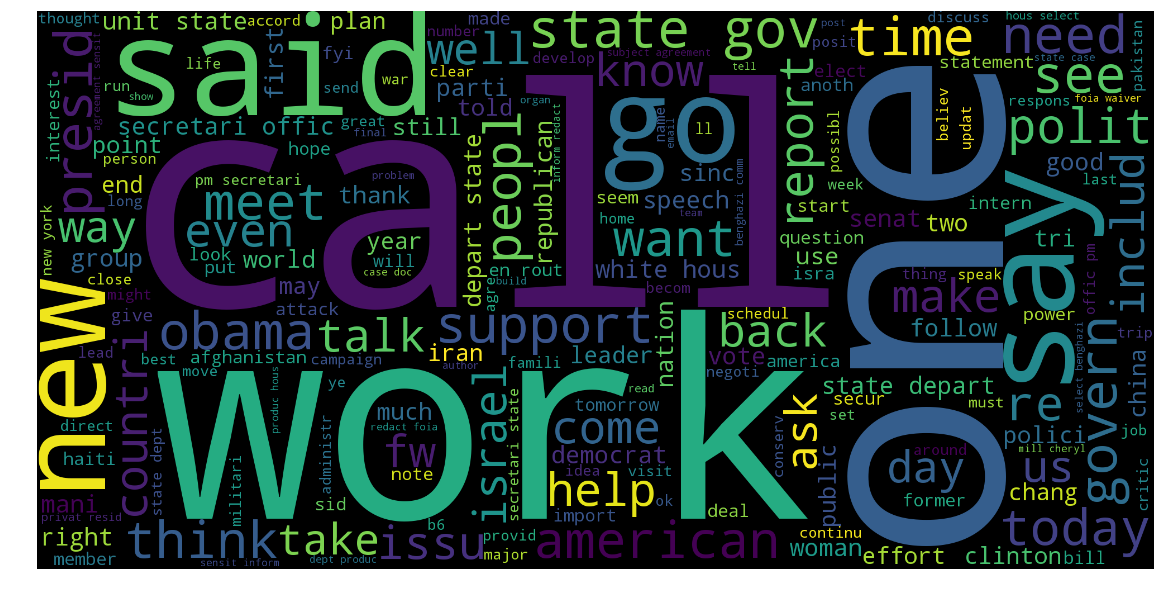

In [109]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

__Summary__: It looks much better now. Some useless words were removed, and items of the same word stem were merged. As a result, better diversity in topics is presented in the viz. On an iterative basis, better results can be acquired if we further extend the stopword list based on the viz. However, this approach cannot tag the tokens, which result in a lack of accuracy when it comes to verbs(e.g. `said` and `say`), or nouns if we choose to lemmatize according to verbs. In this case, we believe nouns would contain more information than verbs, so we forgo the tagging system and chose to follow the pattern of nouns.

## Task 2 - Sentiment analysis of countries

For this task, we are going to do three things:
- Identify country names on each email message
- Perform sentiment analysis on each email message
- Aggregate the polarity information for each country

### Identify country names

Before mapping emails with country names, we need to generate tokens for each email.

In [144]:
extractedMail['Tokens'] = ''
extractedMail['Tokens'] = extractedMail['Tokens'].astype('object')

In [145]:
# get token for each row
def get_token(row):
    mail = extractedMail.loc[row]
    subject_token = preprocessing(mail.ExtractedSubject, english_stopwords, verify=False)
    body_token = preprocessing(mail.ExtractedBodyText, english_stopwords, verify=False)
    subject_token.extend(body_token) # this is the final tokens
    extractedMail.loc[row, 'Tokens'] = subject_token

In [146]:
for row in range(extractedMail.shape[0]):
    get_token(row)

In [148]:
extractedMail.head()

,ExtractedSubject,ExtractedBodyText,Tokens
0,FW: Wow,,"[fw, wow]"
1,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","[b6, thursday, march, 3, 2011, 9:45, pm, h, la..."
2,Re: Chris Stevens,Thx,"[chris, steven, thx]"
3,FVV: Cairo Condemnation - Final,,"[fvv, cairo, condemn, final]"
4,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","[h, hrod17, clintonemail.com, friday, march, 1..."


Cool. Now we will use `pycountry` to identify country names in each email message. A list containing tokens representing each country should be created.

In [175]:
list(pycountry.countries)[:10]

[Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533'),
 Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan'),
 Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola'),
 Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660'),
 Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248'),
 Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania'),
 Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra'),
 Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784'),
 Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic'),
 Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia')]

We think `alpha2`, `alpha3` and `name` fields are the most useful features. No one will use official name in emails, and it will be tokenized anyway.

In [185]:
# create a dict
countries = {}
for country in pycountry.countries:
    countries.update({country.alpha_2: [country.alpha_2, country.alpha_3, country.name]})

Great. However, the name can still be too redundant sometimes(i.e. United Arab Emirates) so we need to add some common or simplified usages into the list. Adjectives can be added for non-trivial countries.

In [187]:
countries['AE'].extend(['UAE'])
countries['AG'].extend(['Antigua', 'Barbuda'])
countries['BA'].extend(['Bosnia', 'Herzegovina'])
countries['BF'].extend(['Burkina', 'Faso'])
countries['BN'].extend(['Brunei'])
countries['BO'].extend(['Bolivia'])
countries['CD'].extend(['Zaire', 'Congo'])
countries['FM'].extend(['Micronesia'])
countries['GB'].extend(['UK', 'Great Britain', 'Britain'])
countries['IR'].extend(['Iran'])
countries['KP'].extend(['North Korea'])
countries['KR'].extend(['South Korea'])
countries['LA'].extend(['Laos'])
countries['MD'].extend(['Moldova'])
countries['MK'].extend(['Macedonia'])
countries['NZ'].extend(['Zealand'])
countries['PS'].extend(['Palestine'])
countries['RU'].extend(['Russia', 'Russian'])
countries['SA'].extend(['Saudi'])
countries['SY'].extend(['Syrian', 'Syria'])
countries['TL'].extend(['East Timor', 'Timor'])
countries['TT'].extend(['Trinidad', 'Tobago'])
countries['TW'].extend(['Taiwan'])
countries['TZ'].extend(['Tanzania'])
countries['US'].extend(['America', 'American'])
countries['VE'].extend(['Venezuela'])
countries['VN'].extend(['Vietnam'])

In [199]:
countries

{'AD': ['AD', 'AND', 'Andorra'],
 'AE': ['AE', 'ARE', 'United Arab Emirates', 'UAE'],
 'AF': ['AF', 'AFG', 'Afghanistan'],
 'AG': ['AG', 'ATG', 'Antigua and Barbuda', 'Antigua', 'Barbuda'],
 'AI': ['AI', 'AIA', 'Anguilla'],
 'AL': ['AL', 'ALB', 'Albania'],
 'AM': ['AM', 'ARM', 'Armenia'],
 'AO': ['AO', 'AGO', 'Angola'],
 'AQ': ['AQ', 'ATA', 'Antarctica'],
 'AR': ['AR', 'ARG', 'Argentina'],
 'AS': ['AS', 'ASM', 'American Samoa'],
 'AT': ['AT', 'AUT', 'Austria'],
 'AU': ['AU', 'AUS', 'Australia'],
 'AW': ['AW', 'ABW', 'Aruba'],
 'AX': ['AX', 'ALA', 'Åland Islands'],
 'AZ': ['AZ', 'AZE', 'Azerbaijan'],
 'BA': ['BA', 'BIH', 'Bosnia and Herzegovina', 'Bosnia', 'Herzegovina'],
 'BB': ['BB', 'BRB', 'Barbados'],
 'BD': ['BD', 'BGD', 'Bangladesh'],
 'BE': ['BE', 'BEL', 'Belgium'],
 'BF': ['BF', 'BFA', 'Burkina Faso', 'Burkina', 'Faso'],
 'BG': ['BG', 'BGR', 'Bulgaria'],
 'BH': ['BH', 'BHR', 'Bahrain'],
 'BI': ['BI', 'BDI', 'Burundi'],
 'BJ': ['BJ', 'BEN', 'Benin'],
 'BL': ['BL', 'BLM', 'Saint B

So we have everything now and it's time to assign emails to each country. For abbreviations, we don't want to check the lower case also; but for full names, we will check both the original string and the lower case string. Following is the implementation.

In [208]:
extractedMail['Countries'] = ''
extractedMail['Countries'] = extractedMail['Countries'].astype('object')

In [221]:
def identify_country(row):
    mail = extractedMail.loc[row]
    countrylist = []
    for country_id, country_name in countries.items():
        for name in country_name:
            if (name in extractedMail.loc[row, 'Tokens']) or ((not name.isupper()) and (name.lower() in extractedMail.loc[row, 'Tokens'])):
                countrylist.extend([country_id])
    extractedMail.loc[row, 'Countries'] = countrylist

In [224]:
for row in range(extractedMail.shape[0]):
    identify_country(row)

### Sentiment analysis

In [242]:
# demo from http://www.nltk.org/howto/sentiment.html
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# use compound value for polarity aggregation
extractedMail['Sentiment'] = np.nan

sid = SentimentIntensityAnalyzer()

def calc_sentiment(row):
    # nltk.download('vader_lexicon')
    if not extractedMail.loc[row, 'Countries']:
        extractedMail.loc[row, 'Sentiment'] = 0.0
    else:
        vader_points = sid.polarity_scores(' '.join(extractedMail.loc[row, 'Tokens']))
        extractedMail.loc[row, 'Sentiment'] = vader_points['compound']

In [243]:
for row in range(extractedMail.shape[0]):
    calc_sentiment(row)

In [247]:
# A good checkpoint to save the file
extractedMail.to_csv(r'data/country_mapping.csv', sep='\t', index=None, encoding='utf-8')
#df = pd.read_csv('data/country_mapping.csv', delimiter='\t')

In [246]:
extractedMail

,ExtractedSubject,ExtractedBodyText,Tokens,Countries,Sentiment
0,FW: Wow,,"[fw, wow]",[],0.0000
1,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","[b6, thursday, march, 3, 2011, 9:45, pm, h, la...","[LY, SY]",0.0000
2,Re: Chris Stevens,Thx,"[chris, steven, thx]",[],0.0000
3,FVV: Cairo Condemnation - Final,,"[fvv, cairo, condemn, final]",[],0.0000
4,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","[h, hrod17, clintonemail.com, friday, march, 1...","[LY, SY]",0.0000
5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,"[meet, the, right, wing, extremist, behind, an...",[],0.0000
6,"FW: Anti-Muslim film director in hiding, follo...",,"[fw, anti-muslim, film, director, hide, follow...","[LY, EG]",-0.1779
7,,"H <hrod17@clintonemail.corn>\nFriday, March 11...","[h, hrod17, clintonemail.corn, friday, march, ...","[LY, SY]",0.0000
8,FVV: Secretary's remarks,FYI,"[fvv, secretari, remark, fyi]",[],0.0000
9,more on Libya,"B6\nWednesday, September 12, 2012 6:16 PM\nFwd...","[libya, b6, wednesday, septemb, 12, 2012, 6:16...",[LY],0.0000


### Aggregate polarity for each country

Since there are two many countries to be evaluated, we will consider only countries that are mentioned in __more than 20 emails.__

In [ ]:
country_df = 